In [1]:
%pip install kagglehub
%pip install datasets
%pip install transformers
%pip install evaluate
%pip install missingno
%pip install jsonlines

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/models

/content/drive/MyDrive/models


In [4]:
import datasets
from datasets import load_dataset
from tqdm import tqdm
import pandas as pd
import numpy as np
# from scipy.spatial.distance import cosine

## Loading Data

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("arshkon/linkedin-job-postings")

print("Path to dataset files:", path)

100%|██████████| 159M/159M [00:04<00:00, 40.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/arshkon/linkedin-job-postings/versions/13


In [6]:
data = pd.read_csv(path + "/postings.csv")
data.head()

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,38480.0,8540.0,34021.0
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,...,NaN,1.712858e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,83200.0,80521.0,8069.0
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,...,We are currently accepting resumes for FOH - A...,1.713278e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,55000.0,45202.0,39061.0
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,...,This position requires a baseline understandin...,1.712896e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,157500.0,11040.0,36059.0
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,3.0,NaN,...,NaN,1.713452e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,70000.0,52601.0,19057.0


### Data Preprocessing

### Deleting missing descriptions

In [7]:
data.isna().sum()

,0
job_id,0
company_name,1719
title,0
description,7
max_salary,94056
pay_period,87776
location,0
company_id,1717
views,1689
med_salary,117569


In [8]:
data = data[data['description'].notna()]
data.isna().sum()

,0
job_id,0
company_name,1718
title,0
description,0
max_salary,94050
pay_period,87770
location,0
company_id,1716
views,1689
med_salary,117562


In [9]:
data = data[['job_id', 'title', 'description']]
data.head()

,job_id,title,description
0,921716,Marketing Coordinator,Job descriptionA leading real estate firm in N...
1,1829192,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ..."
2,10998357,Assitant Restaurant Manager,The National Exemplar is accepting application...
3,23221523,Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...
4,35982263,Service Technician,Looking for HVAC service tech with experience ...


In [10]:
len(data)

123842

### Categorize job postings by descriptions

**By keywords in description and title**

In [11]:
categories = ['INFORMATION-TECHNOLOGY',
    'BUSINESS-DEVELOPMENT',
    'FINANCE',
    'ADVOCATE',
    'ACCOUNTANT',
    'ENGINEERING',
    'CHEF',
    'AVIATION',
    'FITNESS',
    'SALES',
    'BANKING',
    'HEALTHCARE',
    'CONSULTANT',
    'CONSTRUCTION',
    'PUBLIC-RELATIONS',
    'HR',
    'DESIGNER',
    'ARTS',
    'TEACHER',
    'APPAREL',
    'DIGITAL-MEDIA',
    'AGRICULTURE',
    'AUTOMOBILE',
    'BPO',]
# categories_enum = list(enumerate(categories))

In [12]:
keywords = {'INFORMATION-TECHNOLOGY': ['Program', 'Network Security', 'operating system', 'database', 'tech', 'IT ', 'IT-', 'IT)', '(IT'],
  'BUSINESS-DEVELOPMENT': ['business', 'marketing', "BD", "BUSINESS DEVELOPMENT", "Store Mgr", "store manager", 'BST Engagement Lead', 'BST', 'Store Manger', 'Store Plan', 'Store Lead', 'Store Director', 'Store Supervisor',],
  'FINANCE': ["finance", 'marketing', 'data analys', 'financial',],
  'ADVOCATE': ['Lawyer', "advocate", 'Legal', 'law ', 'Lawyer', 'Counsel'],
  'ACCOUNTANT': ['business administration', "accountant", "accounting", 'payment', 'account', 'Certified Public Accountant', 'CPA'],
  'ENGINEERING': ["engineer", 'software', 'material', 'testing', 'specification', 'operating system', 'R&D', 'Research and Development', ],
  'CHEF': ["chef", "cook", 'restaurant', 'menu', 'Kitchen'],
  'AVIATION': ["aviation", 'Aircraft', 'Flight', 'Aerospace', 'Cabin Crew', 'Pilot', 'Air'],
  'FITNESS': ["fitness", 'Train', 'Wellness', 'coach',  'Exercise', 'Sports'],
  'SALES': ['marketing', "sales", 'customer', 'client', 'Market', 'store associate', 'Store Assistant', 'Clerk', 'Shopper', 'Retail Associate', 'Store Attendant'],
  'BANKING': ["bank", 'trade', 'market', 'account', 'Investment', 'Loan', 'Credit'],
  'HEALTHCARE': ["health", 'patient', 'medical', 'Nurs', 'Physic', 'Treatment', 'Clinic', 'Therapist', 'CARE'],
  'CONSULTANT': ["consult", 'Project Management', 'management'],
  'CONSTRUCTION': ["construct", 'Building', 'Structural Engineering'],
  'PUBLIC-RELATIONS': ["public relations", 'advertising', 'Media', 'Brand', 'Public'],
  'HR': ["HR", "human resource", 'employee', 'management', 'manager', 'staff', 'Recruit'],
  'DESIGNER': ["design", 'graphic', 'Prototyp', 'UX', 'UI', 'Adobe'],
  'ARTS': ["art", 'Exhibit'],
  'TEACHER': ["teacher", "educat", 'student', 'child', 'school', 'teach', 'classroom'],
  'APPAREL': ["apparel", 'Fashion', 'Textile', 'Clothing', 'Store Tailor', 'Stylist'],
  'DIGITAL-MEDIA': ["digital media", 'Digital', 'Social Media', 'SEO'],
  'AGRICULTURE': ["agricultur", 'Farm', 'Agronom', 'Crop', 'Soil', 'Livestock', 'Agribusiness', 'Pest', 'Irrigation', 'lawn'],
  'AUTOMOBILE': ["automobile", 'Automotive', 'car ', ' car', 'Vehicle', 'Mechanic', 'Safety Test', 'Transportation', 'driver', 'dispatcher'],
  'BPO': ["BPO", 'management', 'marketing', 'commerce', 'Call Center', 'Client', 'Telemarket', 'outsourcing', 'Customer Service', 'commerc'],
}
lowered_keywords = {}
for cat in keywords:
  lowered_keywords[cat] = []
  for k in keywords[cat]:
    lowered_keywords[cat].append(k.lower())
keywords = lowered_keywords

In [13]:
from tqdm import tqdm
from collections import Counter
import os
csv_file_path = "categorized_postings.csv"
if not os.path.exists(csv_file_path):
  cat1 = []
  cat2 = []
  for i in tqdm(range(len(data))):
    c1 = []
    c2 = []
    for key in keywords:
      for k in keywords[key]:
        if k in data.iloc[i]["title"].lower():
          c1.append(key)
        if k in data.iloc[i]["description"][:500].lower():
          c2.append(key)
    cat1.append(c1)
    cat2.append(c2)
  data['title_cat'] = cat1
  data['desc_cat'] = cat2
else:
  data = pd.read_csv(csv_file_path)
data.head()

,Unnamed: 0,job_id,title,description,title_cat,desc_cat,category1,category2,category
0,0,921716,Marketing Coordinator,Job descriptionA leading real estate firm in N...,"['BUSINESS-DEVELOPMENT', 'FINANCE', 'SALES', '...","['BUSINESS-DEVELOPMENT', 'FINANCE', 'SALES', '...",SALES,SALES,SALES
1,1,1829192,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...","['ADVOCATE', 'HEALTHCARE', 'HEALTHCARE']","['FITNESS', 'SALES', 'HEALTHCARE', 'HEALTHCARE...",HEALTHCARE,HEALTHCARE,HEALTHCARE
2,2,10998357,Assitant Restaurant Manager,The National Exemplar is accepting application...,"['CHEF', 'HR']","['INFORMATION-TECHNOLOGY', 'CHEF', 'HEALTHCARE...",CHEF,HEALTHCARE,CHEF
3,3,23221523,Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,['ADVOCATE'],"['ADVOCATE', 'ADVOCATE', 'ADVOCATE', 'SALES', ...",ADVOCATE,ADVOCATE,ADVOCATE
4,4,35982263,Service Technician,Looking for HVAC service tech with experience ...,['INFORMATION-TECHNOLOGY'],"['INFORMATION-TECHNOLOGY', 'BUSINESS-DEVELOPME...",INFORMATION-TECHNOLOGY,INFORMATION-TECHNOLOGY,INFORMATION-TECHNOLOGY


In [14]:
if not os.path.exists(csv_file_path):
  c = []
  for i in tqdm(range(len(data))):
    if len(cat1[i]) < 1:
      c.append(np.nan)
    else:
      cnt = Counter(cat1[i]).most_common(1)
      c.append(cnt[0][0])
  data["category1"] = c
data["category1"].value_counts(dropna=False)

,count
category1,
NaN,35499
HEALTHCARE,13270
SALES,13097
INFORMATION-TECHNOLOGY,12306
ENGINEERING,11291
HR,10580
ACCOUNTANT,4637
BUSINESS-DEVELOPMENT,3881
FINANCE,2257


In [15]:
if not os.path.exists(csv_file_path):
  c = []
  for i in tqdm(range(len(data))):
    if len(cat2[i]) < 1:
      c.append(np.nan)
    else:
      cnt = Counter(cat2[i]).most_common(1)
      c.append(cnt[0][0])
  data["category2"] = c
data["category2"].value_counts(dropna=False)

,count
category2,
HEALTHCARE,25743
INFORMATION-TECHNOLOGY,24967
SALES,18280
HR,9897
ENGINEERING,6791
BUSINESS-DEVELOPMENT,6575
DESIGNER,5296
ACCOUNTANT,3707
FINANCE,2380


In [16]:
if not os.path.exists(csv_file_path):
  cat = []
  for i in tqdm(range(len(data))):
    if data.iloc[i]["category1"] == data.iloc[i]["category2"]:
      cat.append(data.iloc[i]["category1"])
    else:
      cat.append(np.nan)
  data["category"] = cat
data["category"].value_counts(dropna=False)

,count
category,
NaN,82441
HEALTHCARE,11253
SALES,6541
INFORMATION-TECHNOLOGY,5645
ENGINEERING,3506
HR,3169
BUSINESS-DEVELOPMENT,2490
ACCOUNTANT,1726
ADVOCATE,1178


**By important keywords in title**

In [17]:
important_keywords = {'INFORMATION-TECHNOLOGY': [], #['Program', 'Network Security', "INFORMATION-TECHNOLOGY", 'operating system', 'database', 'tech', 'IT ', 'IT-', 'IT)', '(IT'],
  'BUSINESS-DEVELOPMENT': ["BUSINESS DEVELOPMENT", "Store Mgr", "store manager", 'BST Engagement Lead', 'BST', 'Store Manger', 'Store Plan', 'Store Lead', 'Store Director', 'Store Supervisor'], #['business', 'marketing', "BD", 'BUSINESS-DEVELOPMENT', "BUSINESS DEVELOPMENT", "Store Mgr", "store manager", 'BST Engagement Lead', 'BST', 'Store Manger', 'Store Plan', 'Store Lead', 'Store Director', 'Store Supervisor',],
  'FINANCE': [], #["finance", 'marketing', 'data analys', 'financial',],
  'ADVOCATE': ["advocate", 'Lawyer', 'Counsel'], #['Lawyer', "advocate", 'Legal', 'law ', 'Lawyer', 'Counsel'],
  'ACCOUNTANT': ['Certified Public Accountant', 'CPA'], #['business administration', "accountant", "accounting", 'payment', 'account', 'Certified Public Accountant', 'CPA'],
  'ENGINEERING': [], #["engineer", 'software', 'material', 'testing', 'specification', 'operating system', 'R&D', 'Research and Development', ],
  'CHEF': ["chef", 'Kitchen', "cook", 'restaurant',], #["chef", "cook", 'restaurant', 'menu', 'Kitchen'],
  'AVIATION': ["aviation", 'Pilot',], #["aviation", 'Aircraft', 'Flight', 'Aerospace', 'Cabin Crew', 'Pilot', 'Air'],
  'FITNESS': ["fitness", 'coach',], #["fitness", 'Train', 'Wellness', 'coach',  'Exercise', 'Sports'],
  'SALES': [], #['marketing', "sales", 'customer', 'client', 'Market', 'store associate', 'Store Assistant', 'Clerk', 'Shopper', 'Retail Associate', 'Store Attendant'],
  'BANKING': [], #["bank", 'trade', 'market', 'account', 'Investment', 'Loan', 'Credit'],
  'HEALTHCARE': [], #["health", 'patient', 'medical', 'Nurs', 'Physic', 'Treatment', 'Clinic', 'Therapist', 'CARE'],
  'CONSULTANT': [], #["consult", 'Project Management', 'management'],
  'CONSTRUCTION': ['construct'], #["construct", 'Building', 'Structural Engineering'],
  'PUBLIC-RELATIONS': ["public relations", 'advertising', ], #["public relations", 'advertising', 'Media', 'Brand', 'Public'],
  'HR': ["human resource",], #["HR", "human resource", 'employee', 'management', 'manager', 'staff', 'Recruit'],
  'DESIGNER': [], #["design", 'graphic', 'Prototyp', 'UX', 'UI', 'Adobe'],
  'ARTS': [], #["art", 'Exhibit'],
  'TEACHER': [], #["teacher", "educat", 'student', 'child', 'school', 'teach', 'classroom'],
  'APPAREL': ["apparel", 'Store Tailor', 'Stylist'], #["apparel", 'Fashion', 'Textile', 'Clothing', 'Store Tailor', 'Stylist'],
  'DIGITAL-MEDIA': ["digital media", ], #["digital media", 'Digital', 'Social Media', 'SEO'],
  'AGRICULTURE': ['lawn'], #["agricultur", 'Farm', 'Agronom', 'Crop', 'Soil', 'Livestock', 'Agribusiness', 'Pest', 'Irrigation', 'lawn'],
  'AUTOMOBILE': ["automobile", 'driver', 'dispatcher'], #["automobile", 'Automotive', 'car ', ' car', 'Vehicle', 'Mechanic', 'Safety Test', 'Transportation'],
  'BPO': ["BPO", 'outsourcing', 'commerc'], #["BPO", 'management', 'marketing', 'commerce', 'Call Center', 'Client', 'Telemarket', 'outsourcing', 'Customer Service', 'commerc'],
}
lowered_keywords = {}
for cat in important_keywords:
  lowered_keywords[cat] = []
  for k in important_keywords[cat]:
    lowered_keywords[cat].append(k.lower())
important_keywords = lowered_keywords

In [18]:
for i in tqdm(range(len(data))):
    if data.iloc[i]["category"] is np.nan and data.iloc[i]["category1"] is not np.nan:
      for key in important_keywords[data.iloc[i]["category1"]]:
        if key in data.iloc[i]["title"].lower():
          data.loc[i, "category"] = data.iloc[i]["category1"]

100%|██████████| 123842/123842 [00:18<00:00, 6646.11it/s]


In [19]:
data["category"].value_counts(dropna=False)

,count
category,
NaN,78707
HEALTHCARE,11253
SALES,6541
INFORMATION-TECHNOLOGY,5645
ENGINEERING,3506
BUSINESS-DEVELOPMENT,3472
HR,3314
ACCOUNTANT,1733
ADVOCATE,1601


In [20]:
diff = []
for i in tqdm(range(len(data))):
    if data.iloc[i]["category1"] != data.iloc[i]["category2"] and data.iloc[i]["category"] is None:
      diff.append(data.iloc[i])
diff = pd.DataFrame(diff)
diff.to_csv("to_be_classified.csv")
diff.head()

100%|██████████| 123842/123842 [00:16<00:00, 7636.31it/s]


""


In [21]:
# excep = {
#   'HEALTHCARE': [1829192, 1218575,263583866, 2147609712, 2147609754, 2147609774, 3887719480	],
#   'FITNESS': [83789755, 228003844],
#   'BANKING': [196406165, 658723396, 3902864930],
#   'INFORMATION-TECHNOLOGY': [231010577, 634823509, 3902765077, 3902371340, 3902350223, 3902343817, 3901948163],
#   'ADVOCATE': [243731357, 3901992072, 3832103385, 3867562444, 3884898683, 3884940529, 3885843695, 3885386358, 3887877001, 3887865343, 3887704157, 3887497730, 3888028846, 3889112786, 3898172135],
#   'SALES': [857299959, 3898172227, 3904037951, 3904723423, 3903837729],
#   'APPAREL': [3902363948, 3902757458, 3904716962, 3886448000, 3887835719, 3905325843, 3905304698, 3901966569],
#   'AVIATION': [3889111569, 3891073580, 3891278434, 3891284769, 3894283571, 3898162683, 3898162710, 3903807545, 3900954409, 3901169271, 3901942765, 3901960675,
#     3901963530, 3902362502, 3903428592, 3905295247, 3905336482, 3905823101, 3906095559, 3906226016],
#   'CONSULTANT': [3901454554, 3902757308, 3902747864, 3902305137, 3884433143, 3884433337, 3906256558],
#   'TEACHER': [3889741864, 3903456406, 3906249626, 3889749528, 3902815073],
#   'HR': [3891256442, 3885858647],
#   'BUSINESS-DEVELOPMENT': [3905335507, 3901961067, 3887485826, 3884829936],
#   'FINANCE': [3887888906, 3887892650, 3887894369, 3901929088],
#   'ENGINEERING': [3903462714, 3889411969, 3903477335, 3884434302],
#   'CHEF': [3889278261, 3901937604, 3902356373, 3901996404, 3887551903],
#   'ACCOUNTANT': [3901960519, 3884917608	],
#   'AGRICULTURE': [3885100785],
#   'CONSTRUCTION': [3885106147, ]
# }

In [22]:
# exception_map = {}
# for cat in excep:
#   for docid in excep[cat]:
#     exception_map[docid] = cat

In [23]:
data.to_csv("categorized_postings.csv")

# Train model

## Prepare traning data

In [24]:
data = pd.read_csv("categorized_postings.csv")
data.head()

,Unnamed: 0.1,Unnamed: 0,job_id,title,description,title_cat,desc_cat,category1,category2,category
0,0,0,921716,Marketing Coordinator,Job descriptionA leading real estate firm in N...,"['BUSINESS-DEVELOPMENT', 'FINANCE', 'SALES', '...","['BUSINESS-DEVELOPMENT', 'FINANCE', 'SALES', '...",SALES,SALES,SALES
1,1,1,1829192,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...","['ADVOCATE', 'HEALTHCARE', 'HEALTHCARE']","['FITNESS', 'SALES', 'HEALTHCARE', 'HEALTHCARE...",HEALTHCARE,HEALTHCARE,HEALTHCARE
2,2,2,10998357,Assitant Restaurant Manager,The National Exemplar is accepting application...,"['CHEF', 'HR']","['INFORMATION-TECHNOLOGY', 'CHEF', 'HEALTHCARE...",CHEF,HEALTHCARE,CHEF
3,3,3,23221523,Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,['ADVOCATE'],"['ADVOCATE', 'ADVOCATE', 'ADVOCATE', 'SALES', ...",ADVOCATE,ADVOCATE,ADVOCATE
4,4,4,35982263,Service Technician,Looking for HVAC service tech with experience ...,['INFORMATION-TECHNOLOGY'],"['INFORMATION-TECHNOLOGY', 'BUSINESS-DEVELOPME...",INFORMATION-TECHNOLOGY,INFORMATION-TECHNOLOGY,INFORMATION-TECHNOLOGY


In [25]:
for i in tqdm(range(len(data))):
  data.loc[i, "description_trunc"] = data.iloc[i]["description"][:512]

100%|██████████| 123842/123842 [00:36<00:00, 3411.73it/s]


In [26]:
df = data[["description_trunc", "category"]]
df = df[~df["category"].isna()]
df = df.rename(columns={"description_trunc": "text", "category": "labels"})
df.head()

,text,labels
0,Job descriptionA leading real estate firm in N...,SALES
1,"At Aspen Therapy and Wellness , we are committ...",HEALTHCARE
2,The National Exemplar is accepting application...,CHEF
3,Senior Associate Attorney - Elder Law / Trusts...,ADVOCATE
4,Looking for HVAC service tech with experience ...,INFORMATION-TECHNOLOGY


In [27]:
len(df)

45135

In [28]:
from datasets import Dataset, DatasetDict
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

# encode the labels for training
# LabelEncoder() helps to track ur labels, which is helpful for accuracies

le = LabelEncoder()
df['labels'] = le.fit_transform(df['labels'])

train, validate = \
              np.split(df.sample(frac=1, random_state=10),
                       [int(.9*len(df))])

# reset indices
train = train.reset_index()[['text','labels']]
validate = validate.reset_index()[['text','labels']]

# dataframes to datadict
tds = Dataset.from_pandas(train)
vds = Dataset.from_pandas(validate)
dataset = DatasetDict()
dataset['train'] = tds
dataset['validation'] = vds

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [29]:
pd.DataFrame(dataset["train"]['labels']).value_counts()

,count
0,
18,10140
22,5879
20,5073
15,3140
9,3122
19,2957
0,1573
1,1439
10,1218


In [30]:
pd.DataFrame(dataset["validation"]['labels']).value_counts()

,count
0,
18,1113
22,662
20,572
15,366
19,357
9,350
1,162
0,160
5,139


## Tokenization

In [31]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased" # or path of the model for in local storage
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [32]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [33]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/40621 [00:00<?, ? examples/s]

Map:   0%|          | 0/4514 [00:00<?, ? examples/s]

In [34]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [35]:
import evaluate

accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

## Train

In [36]:
labels = le.classes_
id2label = {}
label2id = {}

for i, cat in enumerate(labels):
    id2label[i] = cat
    label2id[cat] = i
id2label, label2id

({0: 'ACCOUNTANT',
  1: 'ADVOCATE',
  2: 'AGRICULTURE',
  3: 'APPAREL',
  4: 'ARTS',
  5: 'AUTOMOBILE',
  6: 'AVIATION',
  7: 'BANKING',
  8: 'BPO',
  9: 'BUSINESS-DEVELOPMENT',
  10: 'CHEF',
  11: 'CONSTRUCTION',
  12: 'CONSULTANT',
  13: 'DESIGNER',
  14: 'DIGITAL-MEDIA',
  15: 'ENGINEERING',
  16: 'FINANCE',
  17: 'FITNESS',
  18: 'HEALTHCARE',
  19: 'HR',
  20: 'INFORMATION-TECHNOLOGY',
  21: 'PUBLIC-RELATIONS',
  22: 'SALES',
  23: 'TEACHER'},
 {'ACCOUNTANT': 0,
  'ADVOCATE': 1,
  'AGRICULTURE': 2,
  'APPAREL': 3,
  'ARTS': 4,
  'AUTOMOBILE': 5,
  'AVIATION': 6,
  'BANKING': 7,
  'BPO': 8,
  'BUSINESS-DEVELOPMENT': 9,
  'CHEF': 10,
  'CONSTRUCTION': 11,
  'CONSULTANT': 12,
  'DESIGNER': 13,
  'DIGITAL-MEDIA': 14,
  'ENGINEERING': 15,
  'FINANCE': 16,
  'FITNESS': 17,
  'HEALTHCARE': 18,
  'HR': 19,
  'INFORMATION-TECHNOLOGY': 20,
  'PUBLIC-RELATIONS': 21,
  'SALES': 22,
  'TEACHER': 23})

In [37]:
import transformers
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

transformers.set_seed(1111)
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=len(id2label), id2label=id2label, label2id=label2id
)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
training_args = TrainingArguments(
    output_dir="job_classification",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    # push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_encoded["train"],
    eval_dataset=dataset_encoded["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

<ipython-input-38-6e998b69397d>:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
1,0.681400,0.654585,0.847142
2,0.548400,0.603732,0.855560
3,0.452600,0.594357,0.867523
4,0.392700,0.614756,0.869296
5,0.339500,0.630820,0.868852


TrainOutput(global_step=12695, training_loss=0.5293921573934897, metrics={'train_runtime': 6813.7917, 'train_samples_per_second': 29.808, 'train_steps_per_second': 1.863, 'total_flos': 1.640153945416896e+16, 'train_loss': 0.5293921573934897, 'epoch': 5.0})

In [39]:
trainer.save_model("./job_classification_12101210")

## Inference

In [40]:
index = 2000
text = data.iloc[index]["description"][:512]
print(data.iloc[index]["title"], data.iloc[index]["category"])
print(data.iloc[index]["description"])

Urgent Care Advanced Practitioner- NorthPointe HEALTHCARE
Provides nursing and medical services to assigned patients according to the Scope of Practice for Nurse Practitioners as identified by the American Academy of Nurse Practitioners OR as a Physician Associate provides primary health care and performs selective medical services under the direction of the Urgent Care Medical Director. In addition to diagnosing and managing acute and chronic illnesses, the Urgent Care Advanced Practitioner emphasizes health promotion and disease prevention; orders, conducts and interprets diagnostic and laboratory tests, and prescribes pharmacologic agents and nonpharmacological therapies.

Principal Job Functions

 *Commits to the mission, vision, beliefs and consistently demonstrates our core values. *Performs and documents medical history and physical examinations on patients; establishes presumptive diagnosis, which are to be countersigned by the responsible physician; reviews patient records. *R

In [41]:
from transformers import pipeline

classifier = pipeline("text-classification", model="./job_classification_12101210", device='cuda')
classifier(text)

[{'label': 'HEALTHCARE', 'score': 0.9834603667259216}]

## Evaluation

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [43]:
validation_predict = classifier(dataset["validation"]["text"])

In [44]:
predict = []
truth = []
for i in tqdm(range(len(validation_predict))):
  predict.append(validation_predict[i]['label'])
  truth.append(id2label[dataset["validation"]["labels"][i]])

100%|██████████| 4514/4514 [00:09<00:00, 464.29it/s]


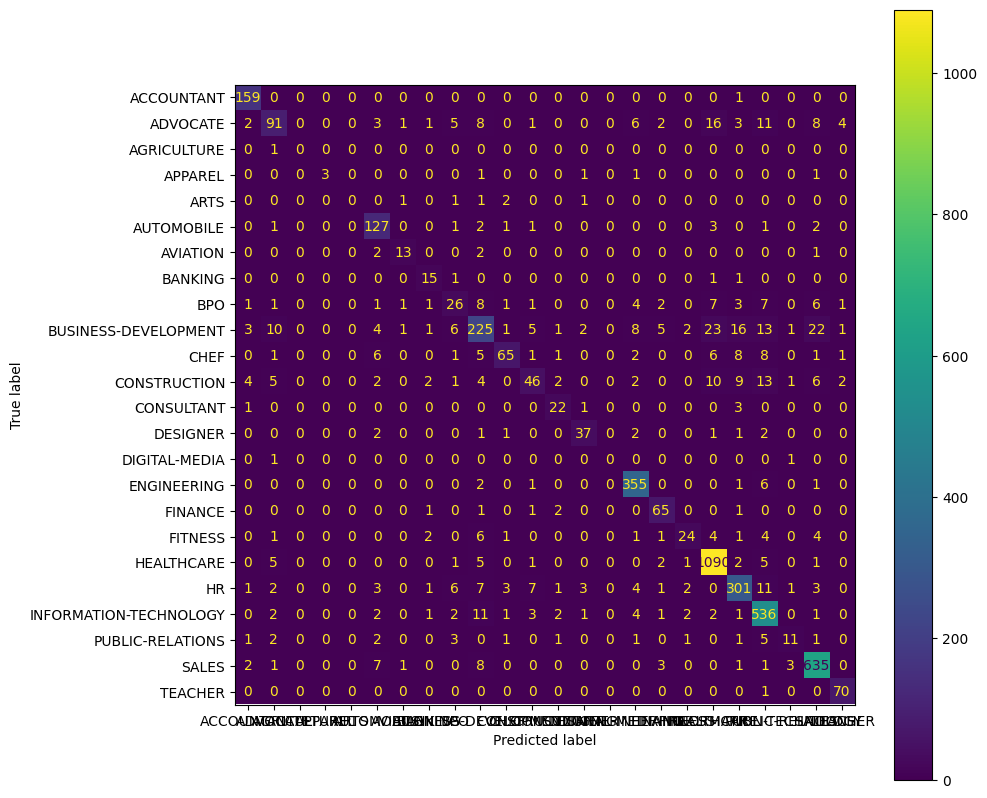

In [45]:
fig, ax = plt.subplots(figsize=(10,10))
cm = confusion_matrix(truth, predict, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
plt.xticks(rotation=30)
disp.plot(ax=ax)

## Prediction

In [46]:
predicted = []
scores = []
for i in tqdm(range(len(data))):
  results = classifier(data.iloc[i]["description_trunc"])
  predicted.append(results[0]["label"])
  scores.append(results[0]["score"])

data["predicted"] = predicted
data["scores"] = scores

100%|██████████| 123842/123842 [13:18<00:00, 155.03it/s]


In [47]:
data.head()

,Unnamed: 0.1,Unnamed: 0,job_id,title,description,title_cat,desc_cat,category1,category2,category,description_trunc,predicted,scores
0,0,0,921716,Marketing Coordinator,Job descriptionA leading real estate firm in N...,"['BUSINESS-DEVELOPMENT', 'FINANCE', 'SALES', '...","['BUSINESS-DEVELOPMENT', 'FINANCE', 'SALES', '...",SALES,SALES,SALES,Job descriptionA leading real estate firm in N...,SALES,0.977695
1,1,1,1829192,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...","['ADVOCATE', 'HEALTHCARE', 'HEALTHCARE']","['FITNESS', 'SALES', 'HEALTHCARE', 'HEALTHCARE...",HEALTHCARE,HEALTHCARE,HEALTHCARE,"At Aspen Therapy and Wellness , we are committ...",HEALTHCARE,0.927411
2,2,2,10998357,Assitant Restaurant Manager,The National Exemplar is accepting application...,"['CHEF', 'HR']","['INFORMATION-TECHNOLOGY', 'CHEF', 'HEALTHCARE...",CHEF,HEALTHCARE,CHEF,The National Exemplar is accepting application...,CHEF,0.974691
3,3,3,23221523,Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,['ADVOCATE'],"['ADVOCATE', 'ADVOCATE', 'ADVOCATE', 'SALES', ...",ADVOCATE,ADVOCATE,ADVOCATE,Senior Associate Attorney - Elder Law / Trusts...,ADVOCATE,0.957392
4,4,4,35982263,Service Technician,Looking for HVAC service tech with experience ...,['INFORMATION-TECHNOLOGY'],"['INFORMATION-TECHNOLOGY', 'BUSINESS-DEVELOPME...",INFORMATION-TECHNOLOGY,INFORMATION-TECHNOLOGY,INFORMATION-TECHNOLOGY,Looking for HVAC service tech with experience ...,INFORMATION-TECHNOLOGY,0.970973


**Basic analysis of prediction**

In [48]:
data['predicted'].value_counts()

,count
predicted,
INFORMATION-TECHNOLOGY,22758
HEALTHCARE,20041
SALES,15096
BUSINESS-DEVELOPMENT,13313
HR,9138
ENGINEERING,7891
ADVOCATE,5215
AUTOMOBILE,4445
ACCOUNTANT,3788


In [49]:
data.to_csv("predicted_postings.csv")

In [50]:
max(data['scores']), min(data['scores'])

(0.9955862760543823, 0.10126540064811707)

<ipython-input-51-9b36fb103e09>:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(scores, shade=True)


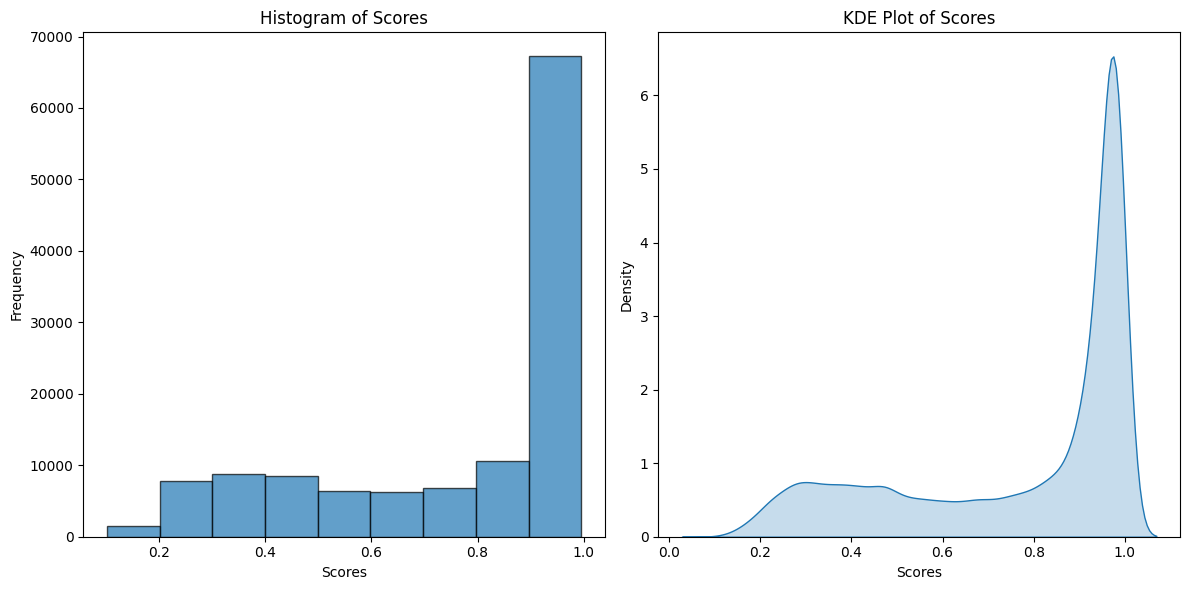

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example list of scores

# Plotting the histogram
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(data['scores'], bins=9, edgecolor='k', alpha=0.7)
plt.title('Histogram of Scores')
plt.xlabel('Scores')
plt.ylabel('Frequency')

# Plotting the KDE
plt.subplot(1, 2, 2)
sns.kdeplot(scores, shade=True)
plt.title('KDE Plot of Scores')
plt.xlabel('Scores')
plt.ylabel('Density')

# Show the plots
plt.tight_layout()
plt.show()

**Confusion matrix for all predictions**

In [52]:
predict = []
truth = []
for i in tqdm(range(len(data))):
  predict.append(data.iloc[i]['predicted'])
  truth.append(data.iloc[i]['category'])

100%|██████████| 123842/123842 [00:17<00:00, 7149.92it/s] 


In [53]:
len(predict)

123842

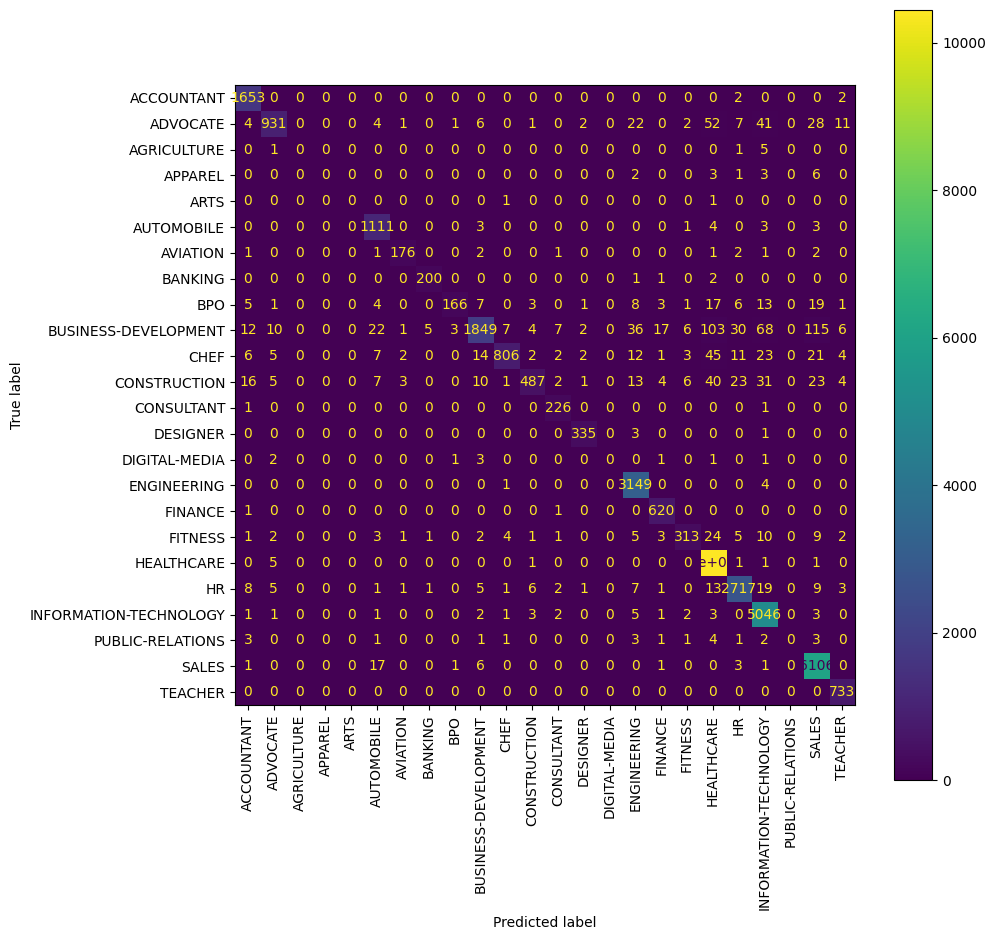

In [60]:
fig, ax = plt.subplots(figsize=(10,10))
cm = confusion_matrix(truth, predict, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, xticks_rotation='vertical')

**Confusion matrix of scores over 0.9**

In [55]:
predict = []
truth = []
for i in tqdm(range(len(data))):
  if data.iloc[i]['scores'] > 0.9:
    predict.append(data.iloc[i]['predicted'])
    truth.append(data.iloc[i]['category'])

100%|██████████| 123842/123842 [00:14<00:00, 8438.24it/s]


In [56]:
len(predict)

66439

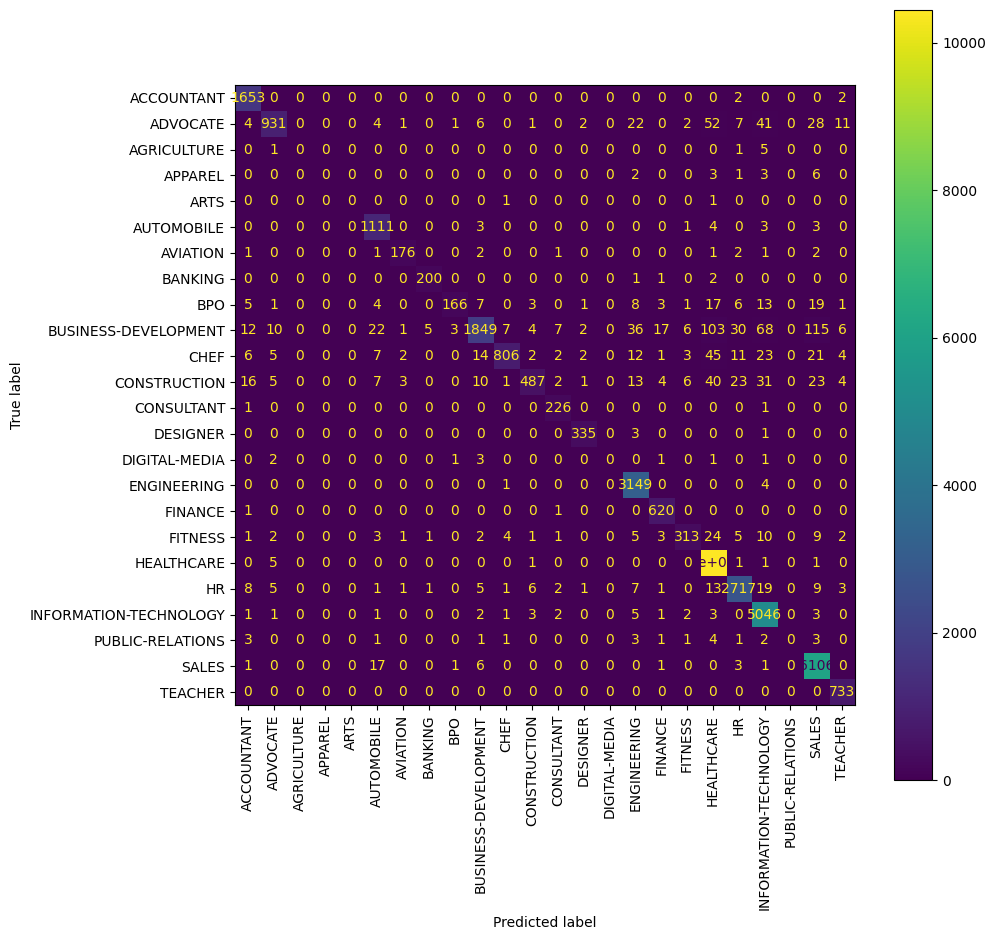

In [59]:
fig, ax = plt.subplots(figsize=(10,10))
cm = confusion_matrix(truth, predict, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, xticks_rotation='vertical')